# Optimal Strategy Analysis for Congklak (Mancala)
This notebook:
- Implements full Congklak rules (7 holes per side + 1 store each)
- Implements strategies: random, greedy, one-ply lookahead
- Runs tournaments and opening experiments
- Produces summary tables, plots, and Markov-chain / heatmap analyses

Instructions:
- Run cells top-to-bottom.
- Change parameters (number of simulated games, strategies) in the "Experiments" cell.

In [26]:
import random
import pandas as pd
import matplotlib.pyplot as plt

## Board Setup:
Board indexing : 
- Player A (south): holes 0..n-1, store at n_holes
- Player B (north): holes 8..2n, store at n_holes+1

In [27]:
n_holes = 6
n_seeds = 4

In [28]:
# === INITIAL SETUP ===
def init_board():
    global n_holes, n_seeds
    board = [n_seeds] * n_holes + [0] + [n_seeds] * n_holes + [0]
    return board

# === DISPLAY BOARD ===
def display_board(board):
    global n_holes
    top_row = board[n_holes+1:-1][::-1]
    bottom_row = board[:n_holes]
    store_A = board[n_holes]
    store_B = board[-1]
    print("   ", "  ".join(f"[{v:2d}]" for v in top_row))
    print(f"[{store_B:2d}]" + " " * (6*n_holes - 2) + f"[{store_A:2d}]")
    print("   ", "  ".join(f"[{v:2d}]" for v in bottom_row))
    
initial_board = init_board()
board = initial_board
display_board(board)

    [ 4]  [ 4]  [ 4]  [ 4]  [ 4]  [ 4]
[ 0]                                  [ 0]
    [ 4]  [ 4]  [ 4]  [ 4]  [ 4]  [ 4]


# Game Setup

In [29]:
# === GAME STATUS ===
def game_over(board):
    # Cek apakah permainan selesai (salah satu sisi kosong).
    global n_holes
    return sum(board[:n_holes]) == 0 or sum(board[n_holes+1:-1]) == 0

# === SIMULATE MOVE ===
def simulate_move(board, move, player):
    # Simulasikan satu langkah permainan Congklak.
    global n_holes
    board = board.copy()
    total_len = len(board)

    if player == 'A':
        if board[move] == 0:
            return board, False
        seeds = board[move]
        board[move] = 0
        pos = move
        while seeds > 0:
            pos = (pos + 1) % total_len
            if pos == total_len - 1:  # skip rumah lawan (B)
                continue
            board[pos] += 1
            seeds -= 1
        extra_turn = (pos == n_holes)
        
        #shooting for the opposite hole
        if 0 <= pos < n_holes and board[pos] == 1:
            opp = (total_len - 2) - pos
            if board[opp] > 0:  # <--- TAMBAHKAN SYARAT INI
                board[n_holes] += board[opp] + 1
                board[pos] = 0
                board[opp] = 0

    elif player == 'B': 
        move_idx = n_holes + 1 + move
        if board[move_idx] == 0:
            return board, False
        seeds = board[move_idx]
        board[move_idx] = 0
        pos = move_idx
        while seeds > 0:
            pos = (pos + 1) % total_len
            if pos == n_holes:  # skip rumah lawan (A)
                continue
            board[pos] += 1
            seeds -= 1
        extra_turn = (pos == total_len - 1)
        
        #shooting
        if n_holes+1 <= pos < total_len-1 and board[pos] == 1:
            opp = (total_len - 2) - pos
            if board[opp] > 0:  # <--- TAMBAHKAN SYARAT INI
                board[-1] += board[opp] + 1
                board[pos] = 0
                board[opp] = 0
    else: 
        print('no player')

    return board, extra_turn

In [30]:
# === PLAY FULL GAME ===
def play_game(strategy_A, strategy_B):
    global n_holes
    board = init_board()
    game_trace = []
    first_A, first_B = [], []
    turn = 'A'
    turn_count = 0

    # --- MAIN GAME LOOP ---
    while not game_over(board):
        turn_count += 1
        if turn == 'A':
            move = strategy_A(board, 'A')
            first_A.append(move)
            board, extra = simulate_move(board, move, 'A')
            game_trace.append({
                "turn": turn_count, "player": "A", "move": move,
                "store_A": board[n_holes], "store_B": board[-1],
                "board": board.copy()
            })
            turn = 'A' if extra else 'B'
        else:
            move = strategy_B(board, 'B')
            first_B.append(move)
            board, extra = simulate_move(board, move, 'B')
            game_trace.append({
                "turn": turn_count, "player": "B", "move": move,
                "store_A": board[n_holes], "store_B": board[-1],
                "board": board.copy()
            })
            turn = 'B' if extra else 'A'

    # --- Clean the board ---
    board[n_holes] += sum(board[:n_holes])        # store A
    board[-1] += sum(board[n_holes+1:-1])         # store B

    for i in range(n_holes):
        board[i] = 0
        board[n_holes+1+i] = 0
        
    # --- list final condition in the trace ---
    game_trace.append({
        "turn": turn_count + 1, 
        "player": "FINAL", 
        "move": None,
        "store_A": board[n_holes], 
        "store_B": board[-1],
        "board": board.copy()
    })

    return board, pd.DataFrame(game_trace), first_A, first_B


In [31]:
# === PLOT SCORE PROGRESS ===
def plot_score_progress(trace):
    plt.plot(trace["turn"], trace["store_A"], label="Player A Store")
    plt.plot(trace["turn"], trace["store_B"], label="Player B Store")
    plt.xlabel("Turn")
    plt.ylabel("Score")
    plt.legend()
    plt.title("Score Progress per Turn")
    plt.show()

# Analysis of Program Strategies

This document provides a technical overview of the three decision-making logics implemented in the program to simulate Congklak gameplay. Each strategy represents a different level of computational complexity.

---

### 1. Random Strategy
The **Random Strategy** is the most basic logic within the program.
* **Mechanism**: The program identifies all valid moves (holes that are not empty) on the current player's side. It then uses a pseudo-random selection process to pick one of these holes.
* **Characteristics**: This strategy does not perform any evaluation of the board state. It serves as a baseline for performance comparison and does not aim for specific tactical goals like scoring or defense.

### 2. Greedy Strategy
The **Greedy Strategy** is a first-order optimization logic focusing on immediate rewards.
* **Mechanism**: For every possible move, the program runs a single-turn simulation. It calculates the potential increase in the player's store (including seeds gained from the "capture" or *tembakan* rule).
* **Characteristics**: The program always selects the move that yields the highest score for the current turn. It is "shortsighted" as it does not calculate how the board state will look for the opponent's next move.

### 3. Lookahead Strategy (One-Ply)
The **Lookahead Strategy** is the second-order logic in this program, utilizing a predictive responds.
* **Mechanism**: 
    1. The program simulates every legal move for the current player (Player A).
    2. For each resulting board state, it anticipates the opponent's (Player B) best possible response using a *Greedy* evaluation.
    3. It then selects the initial move that maximizes the player's advantage (e.g., maximizing the score difference) after the opponent's counter-move is accounted for.
* **Characteristics**: This strategy is both proactive and defensive. It aims to maximize its own score while simultaneously minimizing the opponent's ability to score on their subsequent turn.

---

### Strategy Comparison Summary

| Strategy | Decision Basis | Performance Profile |
| :--- | :--- | :--- |
| **Random** | Probability | High entropy; lacks objective-driven moves. |
| **Greedy** | Immediate Gain | Efficient in scoring but susceptible to opponent traps. |
| **Lookahead** | Anticipation | Mathematically robust; prioritizes long-term board control. |

In [32]:
# =========================================================
# --- RANDOM STRATEGY ---
# =========================================================
def random_strategy(board, player):
    global n_holes
    if player == 'A':
        valid = [i for i in range(n_holes) if board[i] > 0]
    else:
        valid = [i for i in range(n_holes) if board[n_holes+1+i] > 0]
    return random.choice(valid) if valid else 0

# =========================================================
# --- GREEDY STRATEGY ---
# =========================================================
def greedy_strategy(board, player):
    """Pilih langkah yang langsung menghasilkan skor tertinggi."""
    global n_holes
    best_move, best_score = 0, -float('inf')
    store_A, store_B = n_holes, len(board)-1
    for i in range(n_holes):
        if player == 'A' and board[i] == 0: continue
        if player == 'B' and board[n_holes+1+i] == 0: continue
        new_board, _ = simulate_move(board, i, player)
        score = new_board[store_A] - new_board[store_B] if player == 'A' else new_board[store_B] - new_board[store_A]
        if score > best_score:
            best_score, best_move = score, i
    return best_move

# =========================================================
# --- LOOKAHEAD STRATEGY ---
# =========================================================
def lookahead_strategy(board, player):
    """Evaluasi skor setelah 1 langkah lawan."""
    global n_holes
    opponent = 'B' if player == 'A' else 'A'
    store_A, store_B = n_holes, len(board)-1

    best_move, best_eval = 0, -float('inf')
    for i in range(n_holes):
        if player == 'A' and board[i] == 0: continue
        if player == 'B' and board[n_holes+1+i] == 0: continue

        new_board, _ = simulate_move(board, i, player)
        # lawan main greedy
        opp_move = greedy_strategy(new_board, opponent)
        new_board2, _ = simulate_move(new_board, opp_move, opponent)

        eval_score = new_board2[store_A] - new_board2[store_B] if player == 'A' else new_board2[store_B] - new_board2[store_A]
        if eval_score > best_eval:
            best_eval, best_move = eval_score, i
    return best_move

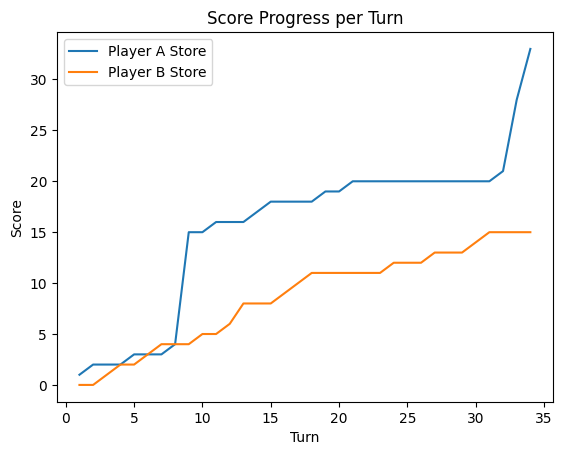

In [33]:
# === EXAMPLE RUN ===
# board, trace, first_A, first_B = play_game(random_strategy, greedy_strategy)
# board, trace, first_A, first_B = play_game(random_strategy, lookahead_strategy)

board, trace, first_A, first_B = play_game(greedy_strategy, lookahead_strategy)
# board, trace, first_A, first_B = play_game(lookahead_strategy, greedy_strategy)

# board, trace, first_A, first_B = play_game(random_strategy, random_strategy)
# board, trace, first_A, first_B = play_game(lookahead_strategy, lookahead_strategy)
# board, trace, first_A, first_B = play_game(greedy_strategy, greedy_strategy)

plot_score_progress(trace)

In [34]:
def display_all_steps(trace_df):
    print(f"=== Menampilkan Total {len(trace_df)} Perpindahan ===")
    
    for index, row in trace_df.iterrows():
        print(f"\nLangkah ke-{row['turn']} | Pemain: {row['player']} | Memilih Lubang: {row['move']+1}")
        # Panggil fungsi display_board asli Anda
        display_board(row['board'])
        print("-" * 40)

# Cara penggunaan:
# Setelah memanggil board, trace, fA, fB = play_game(...)
display_all_steps(trace)

=== Menampilkan Total 34 Perpindahan ===

Langkah ke-1 | Pemain: A | Memilih Lubang: 3.0
    [ 4]  [ 4]  [ 4]  [ 4]  [ 4]  [ 4]
[ 0]                                  [ 1]
    [ 4]  [ 4]  [ 0]  [ 5]  [ 5]  [ 5]
----------------------------------------

Langkah ke-2 | Pemain: A | Memilih Lubang: 4.0
    [ 4]  [ 4]  [ 4]  [ 4]  [ 5]  [ 5]
[ 0]                                  [ 2]
    [ 4]  [ 4]  [ 0]  [ 0]  [ 6]  [ 6]
----------------------------------------

Langkah ke-3 | Pemain: B | Memilih Lubang: 2.0
    [ 5]  [ 5]  [ 5]  [ 5]  [ 0]  [ 5]
[ 1]                                  [ 2]
    [ 4]  [ 4]  [ 0]  [ 0]  [ 6]  [ 6]
----------------------------------------

Langkah ke-4 | Pemain: B | Memilih Lubang: 3.0
    [ 6]  [ 6]  [ 6]  [ 0]  [ 0]  [ 5]
[ 2]                                  [ 2]
    [ 5]  [ 4]  [ 0]  [ 0]  [ 6]  [ 6]
----------------------------------------

Langkah ke-5 | Pemain: A | Memilih Lubang: 5.0
    [ 6]  [ 6]  [ 7]  [ 1]  [ 1]  [ 6]
[ 2]                            

In [ ]:
def play_against_human(computer_strategy):
    global n_holes
    board = init_board()
    _total_len = len(board)
    
    print(f"=== Congklak Game: {n_holes} Lubang ===")
    display_board(board)
    print ("""
           Pilih: 
           1 untuk Pemain A (Jalan Duluan), 
           2 untuk Pemain B (Jalan Kedua) """)

    role = input("Pilih: 1 untuk Pemain A (Jalan Duluan), 2 untuk Pemain B (Jalan Kedua): ")
    human = 'A' if role == '1' else 'B'
    comp = 'B' if human == 'A' else 'A'
    
    def show(b):
        if human == 'A':
            display_board(b)
        else:
            # Memutar tampilan agar sisi B selalu di bawah
            flipped = [0] * _total_len
            for i in range(n_holes):
                flipped[i] = b[n_holes + 1 + i]
                flipped[n_holes + 1 + i] = b[i]
            flipped[n_holes], flipped[-1] = b[-1], b[n_holes]
            print(f"\n(Tampilan: Sisi Anda [Pemain B] di bawah)")
            display_board(flipped)

    turn = 'A'
    show(board)
    
    while not game_over(board):
        print(f"\n>>> Giliran Pemain {turn} <<<")
        
        if turn == human:
            # Identifikasi lubang mana saja yang bisa dipilih (tidak kosong)
            offset = 0 if human == 'A' else n_holes + 1
            valid_user_choices = [i + 1 for i in range(n_holes) if board[offset + i] > 0]
            
            choice = -1
            while choice not in valid_user_choices:
                try:
                    choice = int(input(f"Pilih lubang Anda {valid_user_choices}: "))
                except: print("Masukkan angka!")
            
            # --- SOLUSI SESUAI PERMINTAAN ANDA ---
            if human == 'A':
                move_idx = choice - 1
            else:
                # Untuk Pemain B: Input + n_holes - 1
                # Contoh: Input 1 + 7 - 1 = indeks 7 (Lubang pertama Pemain B)
                move_idx = choice + n_holes - 1
            
            # PENTING: Karena kita sudah menghitung indeks absolut (0-13), 
            # kita harus kirim ke simulate_move dengan role 'A' agar 
            # simulate_move TIDAK menambah n_holes lagi di dalamnya.
            board, extra = simulate_move(board, move_idx, 'A') 
            
        else:
            print("Komputer sedang berpikir...")
            move_idx = computer_strategy(board, comp)
            board, extra = simulate_move(board, move_idx, comp)
            # Tampilan langkah komputer
            view = (move_idx + 1) if comp == 'A' else (move_idx - n_holes)
            print(f"Komputer memilih lubang: {view}")

        show(board)
        turn = turn if extra else ('B' if turn == 'A' else 'A')

    # Finalisasi (Cleaning)
    board[n_holes] += sum(board[:n_holes])
    board[-1] += sum(board[n_holes+1:-1])
    for i in range(_total_len):
        if i != n_holes and i != _total_len - 1: board[i] = 0
    
    show(board)
    s_h = board[n_holes] if human == 'A' else board[-1]
    s_c = board[-1] if human == 'A' else board[n_holes]
    print(f"\nSKOR AKHIR - Anda: {s_h} | Komputer: {s_c}")

In [41]:
# play_against_human(greedy_strategy)

In [42]:
# play_against_human(lookahead_strategy)1

=== Congklak Game: 6 Lubang ===

(Tampilan: Sisi Anda [Pemain B] di bawah)
    [ 4]  [ 4]  [ 4]  [ 4]  [ 4]  [ 4]
[ 0]                                  [ 0]
    [ 4]  [ 4]  [ 4]  [ 4]  [ 4]  [ 4]

>>> Giliran Pemain A <<<
Komputer sedang berpikir...
Komputer memilih lubang: 3

(Tampilan: Sisi Anda [Pemain B] di bawah)
    [ 5]  [ 5]  [ 5]  [ 0]  [ 4]  [ 4]
[ 1]                                  [ 0]
    [ 4]  [ 4]  [ 4]  [ 4]  [ 4]  [ 4]

>>> Giliran Pemain A <<<
Komputer sedang berpikir...
Komputer memilih lubang: 4

(Tampilan: Sisi Anda [Pemain B] di bawah)
    [ 6]  [ 6]  [ 0]  [ 0]  [ 4]  [ 4]
[ 2]                                  [ 0]
    [ 5]  [ 5]  [ 4]  [ 4]  [ 4]  [ 4]

>>> Giliran Pemain B <<<

(Tampilan: Sisi Anda [Pemain B] di bawah)
    [ 6]  [ 6]  [ 0]  [ 0]  [ 4]  [ 4]
[ 0]                                  [ 0]
    [ 6]  [ 6]  [ 4]  [ 4]  [ 4]  [ 4]

>>> Giliran Pemain A <<<
Komputer sedang berpikir...
Komputer memilih lubang: 5

(Tampilan: Sisi Anda [Pemain B] di bawah)
